In [2]:
import pandas as pd
# import gzip
import numpy as np
# import json
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Video_Games_Resampled.csv')

In [3]:
# df = df.reindex(np.random.permutation(df.index))
# ratingonly = df.shape
# df = df.dropna(subset=['overall'],inplace=True)
# df = df.dropna(subset=['reviewText'],inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,Positive Rating
0,346407,129412,5.0,False,"05 3, 2010",A3DID3K8W8QD9W,B0012LHO46,Sam Hartford,bought mine ebay one amazon work fine generics...,PS2 64mb Memory Card is A-OK,1272844800,NaN,NaN,NaN,1
1,19478,204432,4.0,True,"05 5, 2014",A1SPRD853KYUP1,B002I0K956,Oswaldo Romero,nice,Four Stars,1399248000,NaN,NaN,NaN,1
2,349043,367307,5.0,True,"01 4, 2017",A4SV916591F5Z,B00KY1I0IO,Amazon Customer,great fun addicting,Five Stars,1483488000,NaN,{'Format:': ' Video Game'},NaN,1
3,238716,381621,4.0,True,"02 12, 2016",AWXOF97NP6ZZG,B00O9GPD26,Amazon Customer,surprisingly higher quality figure american ve...,The figure is better than the american version.,1455235200,NaN,NaN,NaN,1
4,416659,456490,5.0,False,"08 5, 2005",A3LOOGDJ7S01LA,B00008J2V0,whiterabbit,highly recommended whole family easy instructi...,"Lots of Fun, Lots to Explore!",1123200000,7,NaN,NaN,1


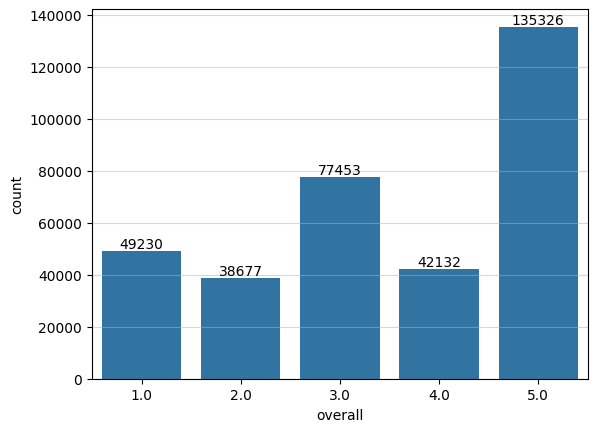

In [13]:
ax=sns.countplot(x='overall', data=df)
ax.bar_label(ax.containers[0])
plt.grid(visible=True,axis='y',alpha=0.5)
plt.show()

In [ ]:
# rating_threshold = 4
# df['Positive Rating'] = df['overall'].apply(lambda x: 1 if x>=rating_threshold else 0)
# df['Positive Rating'].head(10)

In [14]:
# from nltk.corpus import stopwords
# import re
# from nltk.tokenize import word_tokenize, RegexpTokenizer

In [ ]:
# def clean_text(text):
#     # lower text
#     text = text.lower()
#     # remove hyperlinks
#     text = re.compile(r'^https?://', re.IGNORECASE).sub(r'', text)
#     # remove non-letters
#     text = re.sub("[^a-zA-Z]", " ", text)
#     text = word_tokenize(text)
#     # remove stopwords
#     stops = set(stopwords.words("english"))
#     text = [w for w in text if not w in stops]
#     text = " ".join(text)
#     # remove punctuation
#     text = RegexpTokenizer(r'\w+').tokenize(text)
#     text = " ".join(text)
#     # remove words less than 3 letters
#     text = re.sub(r'\b\w{1,2}\b', '', text)
#     return text  



In [ ]:
# df.dropna(subset=['reviewText'],inplace=True)
# df['reviewText'] = df['reviewText'].apply(clean_text)

In [ ]:
# from sklearn.utils import resample

# majority = df[df['Positive Rating']==1]
# minority = df[df['Positive Rating']==0]
# minority_upsampled = resample(minority, replace=True, n_samples=int(len(minority)*1.6), random_state=87)
# majority_downsampled =  resample(majority, replace=True, n_samples=int(len(majority)/2.2), random_state=100)
# resampled_df = pd.concat([majority_downsampled, minority_upsampled])

# print(resampled_df.shape)
# resampled_df['overall'].value_counts()
# resampled_df.to_csv('Video_Games_Resampled.csv')

In [ ]:
# df=pd.read_csv('Video_Games_Resampled.csv')
# df.shape

In [4]:
from sklearn.model_selection import train_test_split

trainx, testx, trainy, testy = train_test_split(df['reviewText'], df['Positive Rating'], test_size=0.23, random_state=42)
print(len(trainx))
print(len(testx))
train = pd.concat([trainx, trainy], axis =1)
test = pd.concat([testx, testy], axis=1)
# train.to_csv('train_data.csv', index=True)
# test.to_csv('test_data.csv',index=True)

263969
78849


In [5]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
# from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn.functional as F
import time
from tqdm import tqdm

In [6]:
import spacy
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
eng = spacy.load("en_core_web_sm")
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")
def engTokenize(text):
    """
    Tokenize an English text and return a list of tokens
    """
    return [token.text for token in eng.tokenizer(text)]

def tokenize(data):
    for x in data:
        yield engTokenize(x)

In [60]:
vocab_train = build_vocab_from_iterator(
    tokenize(trainx),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab_train.set_default_index(vocab_train['<unk>'])
vocab_test = build_vocab_from_iterator(
    tokenize(testx),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab_test.set_default_index(vocab_test['<unk>'])


In [7]:
import pickle
import os

if os.path.exists('vocab_train.pkl'):
    print('Load vocab train')
    with open('vocab_train.pkl', 'rb') as vocab_train_file:
        vocab_train = pickle.load(vocab_train_file)
else:
    # Save the trained vocab_train
    print('Save vocab train')
    with open('vocab_train.pkl', 'wb') as vocab_train_file:
        pickle.dump(vocab_train, vocab_train_file)

if os.path.exists('vocab_test.pkl'):
    print('Load vocab test')
    # Load vocab_test from the pickle file
    with open('vocab_test.pkl', 'rb') as vocab_test_file:
        vocab_test = pickle.load(vocab_test_file)
else:
    print('Save vocab test')
    # Save the trained vocab_test
    with open('vocab_test.pkl', 'wb') as vocab_test_file:
        pickle.dump(vocab_test, vocab_test_file)


print(vocab_train.get_itos()[:45])

Load vocab train
Load vocab test
['<pad>', '<sos>', '<eos>', '<unk>', 'game', ' ', 'like', 'one', 'games', 'get', 'play', 'good', 'really', 'time', 'great', 'fun', 'would', 'much', 'even', 'first', 'also', 'well', 'graphics', 'story', 'new', 'playing', 'way', 'better', 'still', 'make', 'use', 'played', 'many', 'could', 'lot', 'want', 'back', 'little', 'pretty', 'buy', 'gameplay', 'bad', 'people', 'best', 'got']


In [8]:
vocabsize = len(vocab_train)
print(vocabsize)

77587


In [9]:
# Define the dimensions
input_dim = vocabsize # The dimension of your input data (e.g., vocabulary size)
hidden_dim = 256  # Size of the hidden layer
embedding_dim =  128
output_dim = 2  # Two classes: positive and negative
learning_rate = 0.001
epochs = 15
batch_size = 128

In [10]:
# Define the classification model
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        # self.rnn = torch.nn.RNN(embedding_dim,
        #                        hidden_dim,
        #                        nonlinearity='relu')
        self.rnn = torch.nn.LSTM(input_size= embedding_dim,
                                 hidden_size=hidden_dim)        
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, text, length):
        # text dim: [sentence length, batch size]
        
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]
        # Pack the sequences for efficient processing
        packed_data = pack_padded_sequence(embedded, length.sum(1), batch_first=True, enforce_sorted=False)
        output, (hidden, cell) = self.rnn(packed_data)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]
        unpacked_output, unpacked_length = pad_packed_sequence(output,batch_first=True)
        unpacked_output.squeeze_(1)
        # hidden dim: [batch size, hidden dim]
        o = self.fc(unpacked_output)
        return o

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return self.data.iloc[idx], self.labels[idx]



In [12]:
y_train = trainy.values
y_test = testy.values

print(y_train)

[1 1 0 ... 1 1 1]


In [13]:
def getTransform(vocab):
    """
    Create transforms based on given vocabulary. The returned transform is applied to sequence
    of tokens.
    """
    text_tranform = T.Sequential(
        ## converts the sentences to indices based on given vocabulary
        T.VocabTransform(vocab=vocab),
        ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
        # 1 as seen in previous section
        T.AddToken(1, begin=True),
        ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
        # 2 as seen in previous section
        T.AddToken(2, begin=False)
    )
    return text_tranform
def applyTransform(text):
    """
    Apply transforms to sequence of tokens in a sequence pair
    """

    return getTransform(vocab_train)(engTokenize(text))

In [14]:
x_train = trainx.apply(applyTransform)
temp = list(x_train)
print(x_train[3])
x_test = testx.apply(applyTransform)
temp=list(x_test)
print(x_test[0])

[1, 1650, 716, 186, 474, 1775, 93, 27, 2180, 420, 5953, 23089, 474, 27, 6830, 2]
[1, 103, 887, 3489, 7, 326, 67, 279, 27881, 278, 973, 42, 250, 27881, 12294, 4811, 72, 3159, 450, 323, 21, 9, 2614, 8177, 11446, 4811, 134, 36, 5, 3263, 116, 37, 2249, 116, 686, 2035, 1272, 450, 1472, 4811, 289, 1193, 2629, 45, 15703, 1451, 203, 12540, 1918, 5, 973, 67, 279, 1410, 11, 2165, 1272, 450, 1026, 250, 1877, 617, 617, 6423, 151, 444, 7, 973, 79, 137, 7, 716, 186, 4136, 4617, 785, 450, 33, 133, 2329, 1335, 272, 1058, 5931, 53, 5, 450, 62, 150, 39, 2]


In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.set_device(0)
    print("GPU available. Using GPU.")
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")
print(device)

def custom_collate_fn(batch):
    data, labels = zip(*batch)

    # Sort sequences by length (from longest to shortest)
    sorted_data, sorted_labels = zip(*sorted(zip(data, labels), key=lambda x: len(x[0]), reverse=True))

    # Pad sequences to the length of the longest sequence
    padded_data = pad_sequence([torch.tensor(seq) for seq in sorted_data], batch_first=True)
    padded_labels = torch.tensor(sorted_labels, dtype=torch.long)
    onehot_padded_labels = F.one_hot(padded_labels, num_classes=2)

    # Create a mask for the padded elements
    mask = (padded_data != 0).float()

    return padded_data.to(device), mask, onehot_padded_labels.to(device)

GPU available. Using GPU.
cuda


In [17]:
trainset = CustomDataset(x_train, y_train)
testset = CustomDataset(x_test, y_test)

# trainset = CustomDataset(vocab_train, y_train_onehot)
# testset = CustomDataset(vocab_test, y_test)

# Create a DataLoader for your dataset
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

# Move your model to the GPU

# Instantiate the classifier
model = SentimentClassifier(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
# Define the loss function (cross-entropy) and the optimizer (Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
for x,y,z in train_loader:
    print(x)
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
    print(y)
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
    print(z)
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
    # seq_unpacked, lens_unpacked = pad_packed_sequence(x, batch_first=True)
    # print(seq_unpacked)
    break

tensor([[    1,     5,     7,  ..., 18416,   363,     2],
        [    1,   142,     5,  ...,     0,     0,     0],
        [    1,    19,    35,  ...,     0,     0,     0],
        ...,
        [    1,   115,     2,  ...,     0,     0,     0],
        [    1, 13016,     2,  ...,     0,     0,     0],
        [    1,    11,     2,  ...,     0,     0,     0]], device='cuda:0')
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
       

In [19]:
start_time = time.time()
torch.manual_seed(0)

# Wrap train_loader with tqdm
with tqdm(train_loader, unit="batch") as tepoch:
    for epoch in range(epochs):
        print("Training")
        model.train()
        # Wrap train_loader with tqdm to display progress bar
        with tqdm(tepoch, unit="batch") as tbatch:
            for packed_data, mask, labels in tbatch:
                optimizer.zero_grad()
                predictions = model(packed_data, mask)
                loss = criterion(predictions, labels)
                loss.backward()
                optimizer.step()
                tbatch.set_postfix(loss=loss.item())

        # Evaluation on the test set
        print("Testing")
        model.eval()
        total_acc, total_count = 0, 0
        with torch.no_grad():
            correct = 0
            total = 0
            # Wrap test_loader with tqdm to display progress bar
            with tqdm(test_loader, unit="batch") as ttest:
                for packed_data, mask, labels in ttest:
                    predictions = model(packed_data, mask)
                    total_acc += (predictions.argmax(1) == labels).sum().item()
                    total_count += labels.size(0)
                    ttest.set_postfix(accuracy=total_acc / total_count)

        accuracy = total_acc / total_count
        print(f'Epoch [{epoch+1}/{epochs}] | Test Accuracy: {accuracy:.2%}')

# Print total training time
print("Total training time: {:.2f} seconds".format(time.time() - start_time))



  0%|          | 0/2063 [00:00<?, ?batch/s]

Training


100%|██████████| 2063/2063 [20:51<00:00,  1.65batch/s, loss=1.48]


Testing


100%|██████████| 617/617 [00:48<00:00, 12.77batch/s, accuracy=1]


Epoch [1/15] | Test Accuracy: 100.00%
Training


 23%|██▎       | 483/2063 [03:35<11:43,  2.25batch/s, loss=1.31]


KeyboardInterrupt: 